In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random
import math

import torch
import torch.nn as nn
import time

#Feature Selection/Correlation
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor

## Load data

Load the data into tensors.

In [2]:
df = pd.read_csv('data/train.csv')
print(df.shape)
df.head()

(17892, 41)


,ConfirmedCases,Country/Region,Date,Fatalities,ForecastId,Id,Lat,Long,Province/State,Place,...,GDP based on PPP share of world total,Unemployment rate,Population,Life expectancy,Population density,Median age,Urban population %,Hospital beds,Sex ratio,Death rate from lung diseases
0,0.0,Afghanistan,2020-01-22,0.0,NaN,1.0,33.0,65.0,NaN,Afghanistan,...,0.054,NaN,36.51,64.5,60.0,18.0,25.0,0.5,1.03,37.62
1,0.0,Afghanistan,2020-01-23,0.0,NaN,2.0,33.0,65.0,NaN,Afghanistan,...,0.054,NaN,36.51,64.5,60.0,18.0,25.0,0.5,1.03,37.62
2,0.0,Afghanistan,2020-01-24,0.0,NaN,3.0,33.0,65.0,NaN,Afghanistan,...,0.054,NaN,36.51,64.5,60.0,18.0,25.0,0.5,1.03,37.62
3,0.0,Afghanistan,2020-01-25,0.0,NaN,4.0,33.0,65.0,NaN,Afghanistan,...,0.054,NaN,36.51,64.5,60.0,18.0,25.0,0.5,1.03,37.62
4,0.0,Afghanistan,2020-01-26,0.0,NaN,5.0,33.0,65.0,NaN,Afghanistan,...,0.054,NaN,36.51,64.5,60.0,18.0,25.0,0.5,1.03,37.62


In [3]:
for col in df.columns:
    print("'"+col+"',")

'ConfirmedCases',
'Country/Region',
'Date',
'Fatalities',
'ForecastId',
'Id',
'Lat',
'Long',
'Province/State',
'Place',
'Day',
'Cases/day',
'Fatals/day',
'Cases yesterday',
'Cases last week',
'Cases 2weeks ago',
'Cases 3weeks ago',
'Fatals yesterday',
'Fatals last week',
'Fatals 2weeks ago',
'Fatals 3weeks ago',
'Days since 1st case',
'Days since 10th case',
'Days since 100th case',
'Days since 1st fatal',
'Days since 10th fatal',
'Days since 100th fatal',
'Smoking rate',
'Nominal GDP',
'GDP based on PPP',
'GDP per capita',
'GDP based on PPP share of world total',
'Unemployment rate',
'Population',
'Life expectancy',
'Population density',
'Median age',
'Urban population %',
'Hospital beds',
'Sex ratio',
'Death rate from lung diseases',


Start from predicting confirmed cases.

In [4]:
# Select features
col_target = 'Cases/day'
col_features = [
    #'ConfirmedCases',
    #'Country/Region',
    #'Date',
    #'Fatalities',
    #'ForecastId',
    #'Id',
    'Lat',
    'Long',
    #'Province/State',
    #'Place',
    #'Day',
    #'Cases/day',
    #'Fatals/day',
    'Cases yesterday',
    'Cases last week',
    'Cases 2weeks ago',
    'Cases 3weeks ago',
    'Fatals yesterday',
    'Fatals last week',
    'Fatals 2weeks ago',
    'Fatals 3weeks ago',
    'Days since 1st case',
    'Days since 10th case',
    'Days since 100th case',
    'Days since 1st fatal',
    'Days since 10th fatal',
    'Days since 100th fatal',
    'Smoking rate',
    'Nominal GDP',
    'GDP based on PPP',
    'GDP per capita',
    'GDP based on PPP share of world total',
    'Unemployment rate',
    'Population',
    'Life expectancy',
    'Population density',
    'Median age',
    'Urban population %',
    'Hospital beds',
    'Sex ratio',
    'Death rate from lung diseases'
]

In [5]:
# Fill in missing values by column median
for col in col_features:
    df[col] = df[col].fillna(df[col].median())

In [6]:
pd.isna(df[col_features]).sum()

Lat                                      0
Long                                     0
Cases yesterday                          0
Cases last week                          0
Cases 2weeks ago                         0
Cases 3weeks ago                         0
Fatals yesterday                         0
Fatals last week                         0
Fatals 2weeks ago                        0
Fatals 3weeks ago                        0
Days since 1st case                      0
Days since 10th case                     0
Days since 100th case                    0
Days since 1st fatal                     0
Days since 10th fatal                    0
Days since 100th fatal                   0
Smoking rate                             0
Nominal GDP                              0
GDP based on PPP                         0
GDP per capita                           0
GDP based on PPP share of world total    0
Unemployment rate                        0
Population                               0
Life expect

In [7]:
len(col_features)

30

In [13]:
# Original
#Xdata = np.array(df[col_features])
#Ydata = np.array(df[col_target])

# Normalized
Xscaler = MinMaxScaler()
Xscaler.fit(np.array(df[col_features]))
Xdata = Xscaler.transform(np.array(df[col_features]))

Yscaler = MinMaxScaler()
Yscaler.fit(np.array(df[col_target]).reshape(-1, 1))
Ydata = Yscaler.transform(np.array(df[col_target]).reshape(-1, 1)).reshape(1, -1)[0]

In [9]:
# De-normalize Ydata
Ydata2 = Yscaler.inverse_transform(Ydata.reshape(-1, 1)).reshape(1, -1)[0]
print(np.array(df[col_target])[-10:])
print(Ydata2[-10:])

[0 0 0 2 0 0 0 1 0 0]
[0. 0. 0. 2. 0. 0. 0. 1. 0. 0.]


In [12]:
# Original
print(max(Ydata))
print(min(Ydata))

14840
-19849


In [57]:
# Normalized
print(max(Ydata))
print(min(Ydata))

1.0
0.0


In [158]:
# Original
print(Xdata)
print(Ydata)

[[ 33.      65.       0.     ...   0.5      1.03    37.62  ]
 [ 33.      65.       0.     ...   0.5      1.03    37.62  ]
 [ 33.      65.       0.     ...   0.5      1.03    37.62  ]
 ...
 [-15.4167  28.2833   0.     ...   2.       1.      20.04  ]
 [-15.4167  28.2833   1.     ...   2.       1.      20.04  ]
 [-15.4167  28.2833   0.     ...   2.       1.      20.04  ]]
[0 0 0 ... 1 0 0]


In [58]:
# Normalized
print(Xdata)
print(Ydata)

[[0.65794962 0.66940075 0.00416052 ... 0.01423143 0.07392996 0.29011946]
 [0.65794962 0.66940075 0.00416052 ... 0.01423143 0.07392996 0.29011946]
 [0.65794962 0.66940075 0.00416052 ... 0.01423143 0.07392996 0.29011946]
 ...
 [0.23009436 0.55893615 0.00416052 ... 0.12096717 0.06225681 0.1273266 ]
 [0.23009436 0.55893615 0.00422762 ... 0.12096717 0.06225681 0.1273266 ]
 [0.23009436 0.55893615 0.00416052 ... 0.12096717 0.06225681 0.1273266 ]]
[0.57219868 0.57219868 0.57219868 ... 0.57222751 0.57219868 0.57219868]


In [59]:
random.seed(420)
X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2)

In [60]:
np.shape(X_train)

(14313, 30)

In [61]:
Xtrain = torch.Tensor(X_train)
Xtest = torch.Tensor(X_test)
ytrain = torch.Tensor(y_train)
ytest = torch.Tensor(y_test)

Load the data into dataloaders(batches) for stochastic gradient descent.

In [62]:
train = torch.utils.data.TensorDataset(Xtrain, ytrain)
test = torch.utils.data.TensorDataset(Xtest, ytest)

# Set batch size to be the square root of the data points
train_loader = torch.utils.data.DataLoader(train, batch_size=math.ceil(len(Xtrain)**(1/2)),num_workers=2)
test_loader = torch.utils.data.DataLoader(test, batch_size=math.ceil(len(Xtest)**(1/2)), shuffle=False,num_workers=2)

### Feature Selection (Feature importance, and potentially dimensionality reduction)

_The possible choices_

> 1. Correlation heat map
> 2. Extra Tree Regressor
> 3. SelectKBest and Chi2 test

***

In [14]:
# Plot correlation matrix to find out most correlated numerical variables
def correlation_plot(df):
    correlation = df.corr()

    plt.figure(figsize=(16,12))
    plt.title('Correlation Heatmap')
    ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
    plt.show()

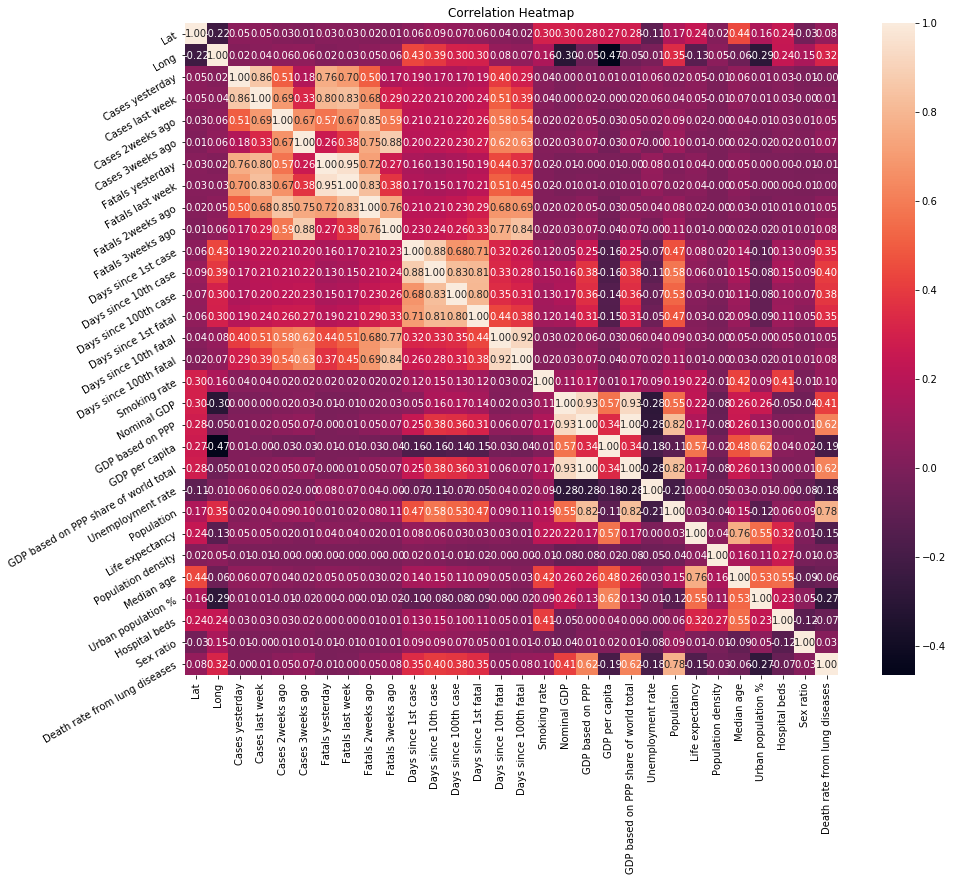

In [15]:
correlation_plot(df[col_features])

In [16]:
def feature_selection_1(dfx,dfy,n):  
    
    X = dfx  #independent columns
    y = dfy  #target column 
       
    #apply SelectKBest class to extract top n best features
    bestfeatures = SelectKBest(score_func=chi2, k=n)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(featureScores.nlargest(n,'Score'))  #print n best features 

In [17]:
# Create normalized Pandas DataFrame for the features part df[col_features]  (SelectKBest can not take negative values)
df_col=df[col_features]
normalized_df_col=(df_col-df_col.min())/(df_col.max()-df_col.min())

feature_selection_1(normalized_df_col,df[col_target],10)

                     Specs        Score
3          Cases last week  5208.345276
8        Fatals 2weeks ago  5123.663409
9        Fatals 3weeks ago  4242.545169
4         Cases 2weeks ago  4071.340834
5         Cases 3weeks ago  3705.923266
14   Days since 10th fatal  3089.885455
7         Fatals last week  2950.322870
15  Days since 100th fatal  2840.516672
10     Days since 1st case  1178.945630
11    Days since 10th case   988.875067


In [18]:
def feature_selection_2(dfx,dfy):  
    
    X = dfx  #independent columns
    y = dfy  #target column   
    
    # Building the model 
    extra_tree_forest = ExtraTreesRegressor(n_estimators=100, criterion='mse', max_features='auto')
    # Training the model 
    extra_tree_forest.fit(X, y) 
    
    # Computing the importance of each feature 
    feature_importance = extra_tree_forest.feature_importances_ 
  
    # Normalizing the individual importances 
    feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extra_tree_forest.estimators_], 
                                        axis = 0) 
#     print(extra_tree_forest.feature_importances_)
    
    feature_importance = pd.Series(feature_importance_normalized, index=list(X.columns) )
   
    ordered_feature_importance = feature_importance.abs()
    ordered_feature_importance_1 = ordered_feature_importance.sort_values(ascending=True)
    ordered_feature_importance_1.plot.barh(figsize=(10,10))
    plt.grid(True)
    plt.show()

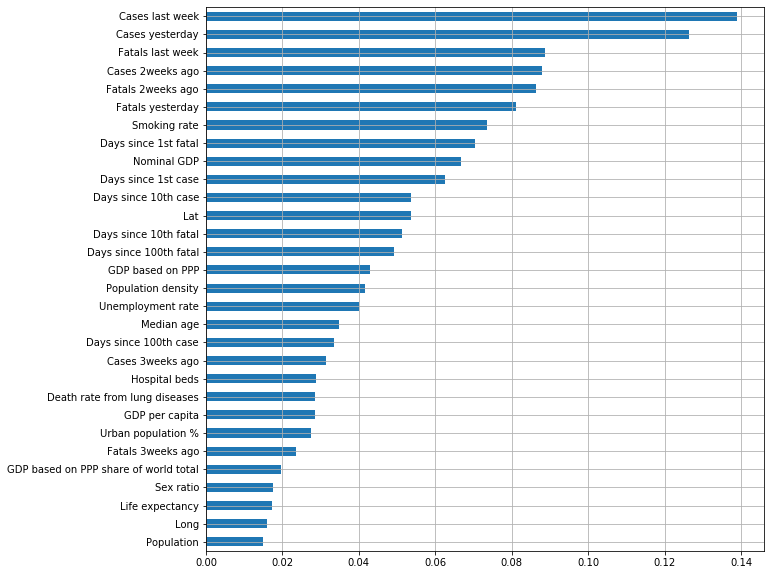

In [19]:
feature_selection_2(df[col_features],df[col_target])

## Build MLP model

Build a three layer neural network for our task. With PyTorch, we only need to specify the forward layers and we get the backpropgation for free.

In [63]:
class My_Net(nn.Module): 
    def __init__(self, input_size, num_neurons):
        super(My_Net, self).__init__()
        # 3 hidden layers
        self.layer_1 = nn.Linear(input_size, num_neurons)
        self.layer_2 = nn.Linear(num_neurons, num_neurons)
        self.layer_3 = nn.Linear(num_neurons, 1)

        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, input_data):
        out = self.layer_1(input_data)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.layer_3(out).view(-1)
        
        return out

In [64]:
len(col_features)

30

In [65]:
# Set one input node for each feature, and make number of hidden nodes equals 2/3 of input nodes
net=My_Net(input_size=len(col_features), num_neurons=int(len(col_features)*2/3))

# MSE loss for regression tasks
loss=nn.MSELoss()

# Use Adam optimizer
opt=torch.optim.Adam(net.parameters(),lr=0.001)

Adam: Denote all parameters as W, W^(t+1) - W^t - alpha x delta(W) x Loss

Define the training and the testing function.

In [66]:
def train_eval():
    loss_sum = 0 # MSE
    num_batches = 0
    for inputs, target in train_loader:
        output = net(inputs)
        loss_sum  += loss(output,target).item()
        num_batches += 1
    
    return loss_sum/num_batches # Return average loss

def test_eval():
    loss_sum = 0 # MSE
    num_batches = 0
    for inputs, target in test_loader:
        output = net(inputs)
        loss_sum  += loss(output,target).item()
        num_batches += 1

    return loss_sum/num_batches # Return average loss

Train the network and report  the training loss/accuracy.

In [67]:
# Initialize the network using Xavier initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)

In [68]:
net.apply(weights_init)

My_Net(
  (layer_1): Linear(in_features=30, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

Start training.

In [69]:
epochs = 100
train_loss_store = []
test_loss_store = []

for epoch in range(epochs):
    time1 = time.time()
    for i, (x,y) in enumerate(train_loader,0):
        opt.zero_grad() # Start each batch with all gradients zero, don't accumulate from past batch
        output = net(x)
        l = loss(output, y)
        l.backward()
        opt.step()
    
    train_loss_store.append(train_eval())
    test_loss_store.append(test_eval())

    time2 = time.time()
    if (epoch+1) % 10 == 0:
        print('In epoch %i : '%(epoch+1))
        print("Time lapse: %f secs" %round((time2-time1),2))

In epoch 10 : 
Time lapse: 0.870000 secs
In epoch 20 : 
Time lapse: 0.770000 secs
In epoch 30 : 
Time lapse: 0.820000 secs
In epoch 40 : 
Time lapse: 0.750000 secs
In epoch 50 : 
Time lapse: 0.830000 secs
In epoch 60 : 
Time lapse: 0.850000 secs
In epoch 70 : 
Time lapse: 0.790000 secs
In epoch 80 : 
Time lapse: 0.730000 secs
In epoch 90 : 
Time lapse: 0.770000 secs
In epoch 100 : 
Time lapse: 0.870000 secs


Visualize the training and testing loss/accuracy.

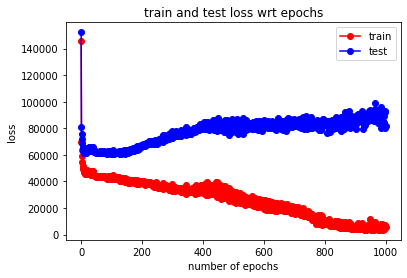

In [167]:
# 1000 epochs, not normalized
plt.plot(train_loss_store,'r-o')
plt.plot(test_loss_store,'b-o')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend(('train','test'),loc='upper right')
plt.title('train and test loss wrt epochs')
plt.show()

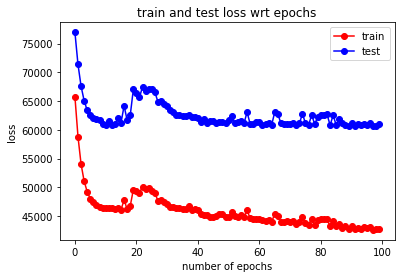

In [188]:
# 100 epochs, not normalized
plt.plot(train_loss_store,'r-o')
plt.plot(test_loss_store,'b-o')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend(('train','test'),loc='upper right')
plt.title('train and test loss wrt epochs')
plt.show()

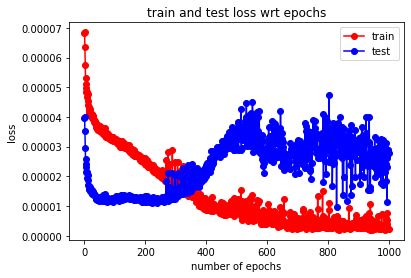

In [219]:
# 1000 epochs, normalized
plt.plot(train_loss_store,'r-o')
plt.plot(test_loss_store,'b-o')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend(('train','test'),loc='upper right')
plt.title('train and test loss wrt epochs')
plt.show()

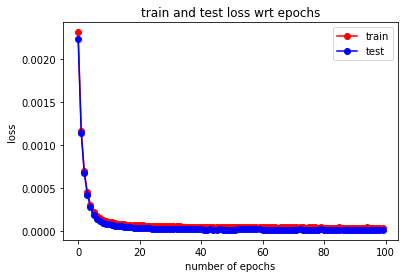

In [223]:
# 100 epochs, normalized
plt.plot(train_loss_store,'r-o')
plt.plot(test_loss_store,'b-o')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend(('train','test'),loc='upper right')
plt.title('train and test loss wrt epochs')
plt.show()

If loss is increasing, we might want to use a smaller learning rate.

## Plot results

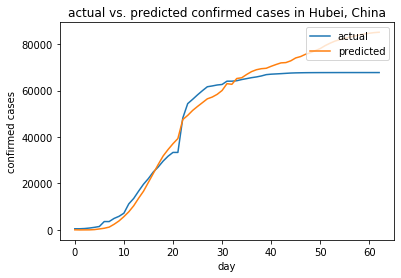

In [89]:
# Test our model on Hubei, China
Xdata_Hubei = Xscaler.transform(np.array(df[df['Place']=='China/Hubei'][col_features]))
Xdata_Hubei = torch.Tensor(Xdata_Hubei)
output = net(Xdata_Hubei).detach().numpy()
output = Yscaler.inverse_transform(output.reshape(-1, 1)).reshape(1, -1)[0] # Denormalize
output = np.cumsum(output) # Cumulatively sum up cases/day to get total confirmed cases

plt.plot(df[df['Place']=='China/Hubei']['ConfirmedCases'].values) # Actual confirmed cases
plt.plot(output)
plt.xlabel('day')
plt.ylabel('confirmed cases')
plt.legend(('actual','predicted'),loc='upper right')
plt.title('actual vs. predicted confirmed cases in Hubei, China')
plt.show()

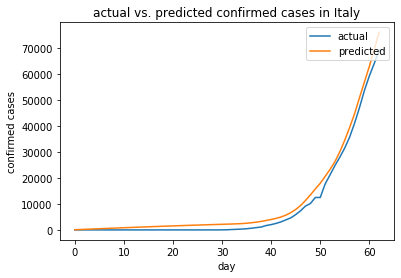

In [90]:
# Test our model on Italy
Xdata_Italy = Xscaler.transform(np.array(df[df['Place']=='Italy'][col_features]))
Xdata_Italy = torch.Tensor(Xdata_Italy)
output = net(Xdata_Italy).detach().numpy()
output = Yscaler.inverse_transform(output.reshape(-1, 1)).reshape(1, -1)[0] # Denormalize
output = np.cumsum(output) # Cumulatively sum up cases/day to get total confirmed cases

plt.plot(df[df['Place']=='Italy']['ConfirmedCases'].values) # Actual confirmed cases
plt.plot(output)
plt.xlabel('day')
plt.ylabel('confirmed cases')
plt.legend(('actual','predicted'),loc='upper right')
plt.title('actual vs. predicted confirmed cases in Italy')
plt.show()

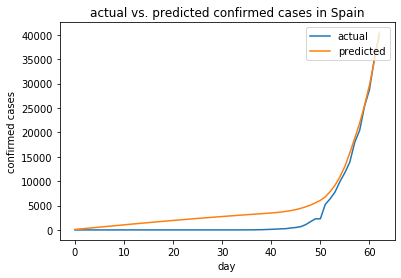

In [109]:
# Test our model on Spain
Xdata_Spain = Xscaler.transform(np.array(df[df['Place']=='Spain'][col_features]))
Xdata_Spain = torch.Tensor(Xdata_Spain)
output = net(Xdata_Spain).detach().numpy()
output = Yscaler.inverse_transform(output.reshape(-1, 1)).reshape(1, -1)[0] # Denormalize
output = np.cumsum(output) # Cumulatively sum up cases/day to get total confirmed cases

plt.plot(df[df['Place']=='Spain']['ConfirmedCases'].values) # Actual confirmed cases
plt.plot(output)
plt.xlabel('day')
plt.ylabel('confirmed cases')
plt.legend(('actual','predicted'),loc='upper right')
plt.title('actual vs. predicted confirmed cases in Spain')
plt.show()

## Permutation feature importance

In [135]:
# True loss
Xdata_all = Xscaler.transform(np.array(df[col_features]))
Xdata_all = torch.Tensor(Xdata_all)
output = net(Xdata_all).detach().numpy()
output = Yscaler.inverse_transform(output.reshape(-1, 1)).reshape(1, -1)[0] # Denormalize
true_loss = loss(torch.Tensor(df['Cases/day'].values), torch.Tensor(output)).item()
print(true_loss)

32749.822265625


In [171]:
# Permutate each columns and calculate loss
import copy

random.seed(300)

col_loss = []
for col in col_features:
    tmp = copy.deepcopy(df)
    tmp[col] = np.random.permutation(df[col].values) # Shuffle the column
    tmp_Xdata_all = Xscaler.transform(np.array(tmp[col_features]))
    tmp_Xdata_all = torch.Tensor(tmp_Xdata_all)
    output = net(tmp_Xdata_all).detach().numpy()
    output = Yscaler.inverse_transform(output.reshape(-1, 1)).reshape(1, -1)[0] # Denormalize
    tmp_loss = loss(torch.Tensor(df['Cases/day'].values), torch.Tensor(output)).item()
    col_loss.append(tmp_loss) # Record the change in loss in percentages

In [172]:
# Record the change in loss in percentages in dictionary. Larger loss indicates larger importance
col_loss_dic = {}
for i in range(len(col_loss)):    
    col_loss_dic[col_features[i]] = (col_loss[i]-true_loss)/true_loss * 100
sorted_loss_dic = {k: v for k, v in sorted(col_loss_dic.items(), key=lambda item: item[1], reverse=True)}

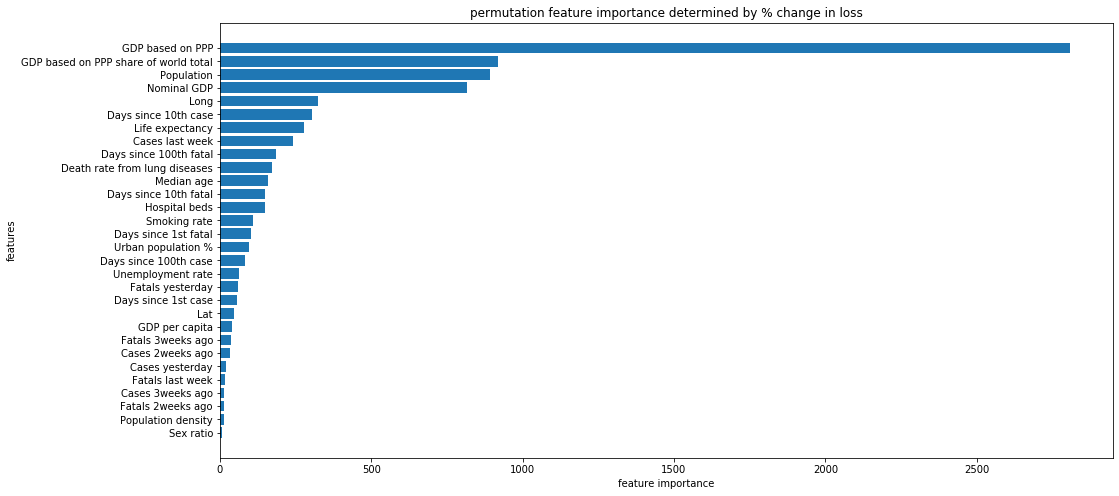

In [170]:
# Visualize feature importance
x = []
y = []
for k, v in sorted_loss_dic.items():
    x.append(k)
    y.append(v)

plt.figure(figsize=(16, 8))
plt.barh(x, y)
plt.gca().invert_yaxis()
plt.xlabel('feature importance')
plt.ylabel('features')
plt.title('permutation feature importance determined by % change in loss')
plt.show()

The importance of GDP is unexpectedly big!

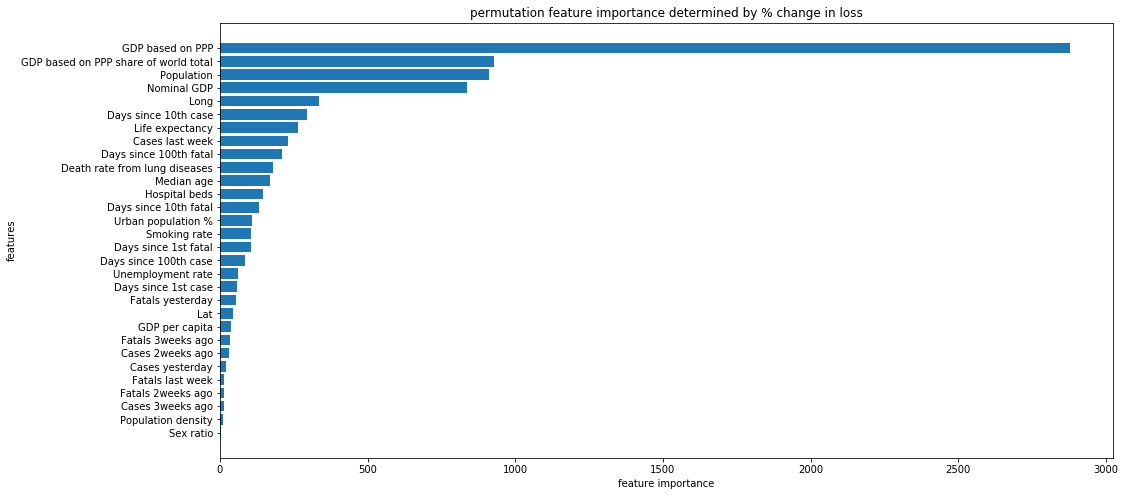

In [173]:
# Visualize feature importance
x = []
y = []
for k, v in sorted_loss_dic.items():
    x.append(k)
    y.append(v)

plt.figure(figsize=(16, 8))
plt.barh(x, y)
plt.gca().invert_yaxis()
plt.xlabel('feature importance')
plt.ylabel('features')
plt.title('permutation feature importance determined by % change in loss')
plt.show()